In [1]:
#Analizzo il caso in cui il qubit non è direttamente controllato e quindi parte del segnale di controllo viene filtrata dal resonator

import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib qt

#costanti fisiche
e = 1.6E-19
h = 6.62E-34
PHI_0 = h/(2*e)
PI = math.pi
hbar = h/(2*PI)

#resonator QubIT
Z_0 = 50
epseff = 6.45  #effective dielectric constant

fr = 7.597*1E9
wr = fr*2*PI

#parametri circuito qubit   
C_s = 93.53976E-15
C_g = 5.43306E-15
I_c = 43E-9
C_k = 6.04E-15
C_r = (PI)/4/wr/Z_0 
L_r = 1/(wr**(2)*C_r) 
C_t = C_r + C_k + C_g*C_s/(C_g+C_s)

'''
fq = 5.304 GHz
fr = 7.597 GHz
Cg = 5.43306 fF
Cs = 93.53976 fF
Ck = 6.04 fF
'''

#Potenza segnale in ingresso (dBm)
P_in_dBm = np.arange(-100, -80, 0.1) #in dBm 
P_in = 10**((P_in_dBm-30)/10)  #! Potenza in dBm definita come 10log(P)

#Calcolo grandezze proprie circuito
beta = C_g/(C_s + C_g)
E_j = PHI_0 * I_c /(2*PI)
E_c = (e**2) / (2* (C_s + C_g))

wp = np.sqrt(8*E_c*E_j)/hbar #frequency se i livelli fossero equispaziati
#w01 = wp - E_c/hbar #transomon frequency
w01 = 5.68*1E9*2*PI

#Calcolo frequenza di rabi
g01 = 2*e*beta*(E_j/(32*E_c))**(1/4)/hbar  #Nota non c'è Vrms poichè si semplifica in w_rab
#FILTRO = w01**2 * L_r * C_k   #attenuazione del segnale che vede il qubit a causa della presenza del filtro nel mezzo
A = w01*(L_r*C_t)**(1/2)    #Numero che mi serve nella formula filtro completa
FILTRO = -w01*C_k*(L_r/C_t)**(1/2) * (A-(1/A))**(-1)
w_rab = g01 * (2* Z_0 * P_in)**(1/2) *FILTRO /(2*PI) /1E6 #* (2*np.sqrt(2)) #Con gli stessi numeri esce leggermente diverso dal file di Alex perchè c'è il fattore 2rad(2) che balla

'''
#Potenza di rumore di una resistenza di 50 ohm che arriva giu
Pn_RMS = 4 * kB * 300 * 1E6 #Quanto deve prendere largo il range di frequenze in cui operare?
Pn_RMS_dB = 10 *np.log10(Pn_RMS*1E3)
#print(Pn_RMS_dB)
'''

#Grafico
plt.figure()
plt.plot(P_in_dBm, w_rab, c='red', linestyle='-.', label='with filter')  
#plt.axvline(x=Pn_RMS_dB, color='red', linestyle='--', label='Thermal Noise') #Plotto la potenza di rumore
plt.xlabel('P_in (dBm)')  # X-axis label
plt.ylabel('w_rab/2π [MHz]')  # Y-axis label
plt.title('w_rab vs. P_in')  # Title of the plot
plt.grid(True)  # Add grid
plt.legend()
plt.show()  # Show the plot

print(w01/(2*PI)/1E9)
print(10*np.log10(FILTRO))

5.68
-16.141781102471132


# S4: It's over Anakin

Programma non ottimizzato

In [1]:
# Grafici rabi in cui tolgo il background calcolato con i punti bassi del trigger
# Noto che il background varia leggermente di file in file

import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib qt

def read_and_process_data(folder_path, prefix="m_LOW", extension=".dat", num_files=None):
    # Initialize lists to store aggregated data
    all_I_means = []
    all_Q_means = []
    all_W_means = []
    deltaT_array = []
    
    # Filter files based on their names
    files_to_read = [file for file in os.listdir(folder_path) if file.startswith(prefix) and file.endswith(extension)]

    if num_files is not None:      # Visto che num_files = None non entro in questo if
        files_to_read = files_to_read[:num_files]

    for file_name in files_to_read:
        file_path = os.path.join(folder_path, file_name)
        
        I = []
        Q = []
        W = []
        I_back = []
        Q_back = []
        W_back = []

        with open(file_path, 'r') as file:
            lines = file.readlines()

            # Skip the first two lines
            lines = lines[2:]

            # Get deltaT
            deltaT = float(lines[0].strip())

            # Skip three lines
            lines = lines[3:]
    
            # Skip 50 initial lines
            lines = lines[50:]

            for i in range(0, len(lines), 500):
                chunk = lines[i+20:i+100]
                chunk_back = lines[i+250:i+499]

                for line in chunk:
                    data = line.strip().split()
                    I.append(float(data[0]))
                    Q.append(float(data[1]))
                    
                for line in chunk_back:
                    data_back = line.strip().split()
                    I_back.append(float(data_back[0]))
                    Q_back.append(float(data_back[1]))

                # Calculate W array for the current chunk
                W.extend(np.sqrt(np.array(I)**2 + np.array(Q)**2))
                W_back.extend(np.sqrt(np.array(I_back)**2 + np.array(Q_back)**2))

        # Calculate mean for I, Q, and W
        mean_I = np.mean(I)
        mean_Q = np.mean(Q)
        mean_W = np.mean(W)
        mean_I_back = np.mean(I_back)
        mean_Q_back = np.mean(Q_back)
        mean_W_back = np.mean(W_back)
        # print(mean_W)
        # print(mean_W_back)
        # print("\n")

        #Leave the background
        mean_I = mean_I - mean_I_back
        mean_Q = mean_Q - mean_Q_back
        mean_W = mean_W - mean_W_back
        
        # Append means to lists
        all_I_means.append(mean_I)
        all_Q_means.append(mean_Q)
        all_W_means.append(mean_W)
        deltaT_array.append(deltaT)

        
    return np.array(all_I_means), np.array(all_Q_means), np.array(all_W_means), np.array(deltaT_array)

# Example usage
folder_path = r'C:\Ale\Universita\Tesi_Magistrale\Dati_Rabi_old\rabi_sweep_dt_500av_fitto'
I_means, Q_means, W_means, deltaT_array = read_and_process_data(folder_path)

sorted_indices = np.argsort(deltaT_array)
deltaT_array = deltaT_array[sorted_indices]
W_means = W_means[sorted_indices]
I_means = I_means[sorted_indices]
Q_means = Q_means[sorted_indices]

# Plotting W vs deltaT
plt.figure(figsize=(8, 6))
plt.scatter(deltaT_array, W_means, color='green', marker='o', edgecolors='black',label='50 punti per trigger ')
plt.plot(deltaT_array, W_means, color='blue', linestyle='-.')
plt.title('W vs deltaT')
plt.xlabel('deltaT')
plt.ylabel('W')
plt.legend()
plt.grid(True)
plt.show()

Profiling

In [2]:
import cProfile
import pstats

# Profile the function
def profile_code():
    folder_path = r'C:\Ale\Universita\Tesi_Magistrale\Dati_Rabi_old\rabi_sweep_dt_500av_fitto'
    I_means, Q_means, W_means, deltaT_array = read_and_process_data(folder_path)

    # Sort and plot
    sorted_indices = np.argsort(deltaT_array)
    deltaT_array = deltaT_array[sorted_indices]
    W_means = W_means[sorted_indices]
    I_means = I_means[sorted_indices]
    Q_means = Q_means[sorted_indices]

    plt.figure(figsize=(8, 6))
    plt.scatter(deltaT_array, W_means, color='green', marker='o', edgecolors='black', label='50 punti per trigger ')
    plt.plot(deltaT_array, W_means, color='blue', linestyle='-.')
    plt.title('W vs deltaT')
    plt.xlabel('deltaT')
    plt.ylabel('W')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run profiling
cProfile.run('profile_code()', 'profiling_results')

# Print the profiling report
with open("profiling_stats.txt", "w") as f:
    stats = pstats.Stats('profiling_results', stream=f)
    stats.strip_dirs()
    stats.sort_stats('cumulative')
    stats.print_stats()

Codice migliorato

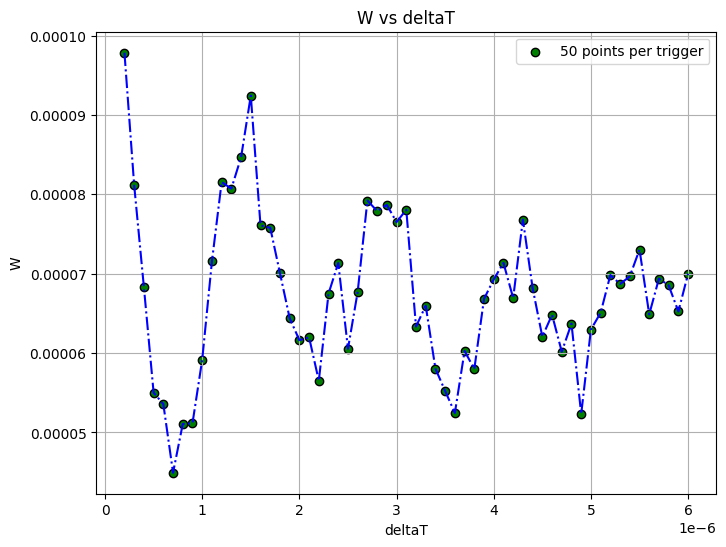

In [1]:
import numpy as np
import os
from numba import jit

@jit(nopython=True)
def compute_means_and_correct(I, Q, I_back, Q_back):

    W = np.sqrt(I**2 + Q**2)  # Compute W
    W_back = np.sqrt(I_back**2 + Q_back**2)  # Compute background W

    # Compute mean and subtract background
    mean_I = np.mean(I) - np.mean(I_back)
    mean_Q = np.mean(Q) - np.mean(Q_back)
    mean_W = np.mean(W) - np.mean(W_back)

    return mean_I, mean_Q, mean_W

def process_data(I_array, Q_array, I_back_array, Q_back_array):
  
    num_files = I_array.shape[0]
    all_I_means = np.zeros(num_files)
    all_Q_means = np.zeros(num_files)
    all_W_means = np.zeros(num_files)

    # Process each file
    for i in range(num_files):
        all_I_means[i], all_Q_means[i], all_W_means[i] = compute_means_and_correct(
            I_array[i], Q_array[i], I_back_array[i], Q_back_array[i]
        )

    return all_I_means, all_Q_means, all_W_means

def read_and_process_data(folder_path, prefix="m_LOW", extension=".dat", num_files=None):

    all_I_means, all_Q_means, all_W_means, deltaT_array = [], [], [], []

    # Filter files based on their names
    files_to_read = [file for file in os.listdir(folder_path) if file.startswith(prefix) and file.endswith(extension)]
    if num_files is not None:
        files_to_read = files_to_read[:num_files]

    I_list, Q_list, I_back_list, Q_back_list = [], [], [], []

    for file_name in files_to_read:
        file_path = os.path.join(folder_path, file_name)
        
        with open(file_path, 'r') as file:
            lines = file.readlines()

            # Skip the first two lines and read deltaT
            deltaT = float(lines[2].strip())
            deltaT_array.append(deltaT)

            # Skip three more lines and 50 initial lines
            lines = lines[55:]

            I, Q, I_back, Q_back = [], [], [], []
            for i in range(0, len(lines), 500):
                chunk = lines[i+20:i+100]
                chunk_back = lines[i+250:i+499]

                for line in chunk:
                    data = line.strip().split()
                    I.append(float(data[0]))
                    Q.append(float(data[1]))

                for line in chunk_back:
                    data_back = line.strip().split()
                    I_back.append(float(data_back[0]))
                    Q_back.append(float(data_back[1]))

            I_list.append(I)
            Q_list.append(Q)
            I_back_list.append(I_back)
            Q_back_list.append(Q_back)

    # Convert lists to numpy arrays for processing
    I_array = np.array([np.array(x) for x in I_list])
    Q_array = np.array([np.array(x) for x in Q_list])
    I_back_array = np.array([np.array(x) for x in I_back_list])
    Q_back_array = np.array([np.array(x) for x in Q_back_list])

    # Use optimized processing
    all_I_means, all_Q_means, all_W_means = process_data(I_array, Q_array, I_back_array, Q_back_array)

    return all_I_means, all_Q_means, all_W_means, np.array(deltaT_array)

# Example usage
folder_path = r'C:\Ale\Universita\Tesi_Magistrale\Dati_Rabi_old\rabi_sweep_dt_500av_fitto'
I_means, Q_means, W_means, deltaT_array = read_and_process_data(folder_path)

# Sort by deltaT for plotting
sorted_indices = np.argsort(deltaT_array)
deltaT_array = deltaT_array[sorted_indices]
W_means = W_means[sorted_indices]
I_means = I_means[sorted_indices]
Q_means = Q_means[sorted_indices]

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(deltaT_array, W_means, color='green', marker='o', edgecolors='black', label='50 points per trigger')
plt.plot(deltaT_array, W_means, color='blue', linestyle='-.')
plt.title('W vs deltaT')
plt.xlabel('deltaT')
plt.ylabel('W')
plt.legend()
plt.grid(True)
plt.show()


Profiling

         15586060 function calls (15586057 primitive calls) in 11.704 seconds

   Ordered by: cumulative time
   List reduced from 106 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    9.592    4.796 interactiveshell.py:3541(run_code)
        2    0.000    0.000    9.592    4.796 {built-in method builtins.exec}
        1    0.154    0.154    9.592    9.592 2708353701.py:1(<module>)
        1    4.969    4.969    9.438    9.438 1793752200.py:33(read_and_process_data)
  7764695    1.769    0.000    1.769    0.000 {method 'append' of 'list' objects}
       59    1.081    0.018    1.692    0.029 {method 'readlines' of '_io._IOBase' objects}
  3882200    1.442    0.000    1.442    0.000 {method 'split' of 'str' objects}
  3882259    1.043    0.000    1.043    0.000 {method 'strip' of 'str' objects}
    27644    0.015    0.000    0.612    0.000 cp1252.py:22(decode)
    27644    0.596    0.000    0.596    0.00

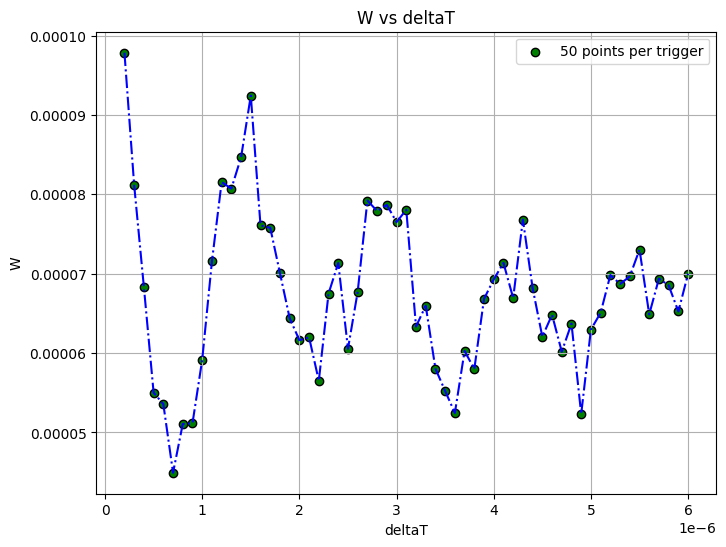

In [3]:
import cProfile
import pstats

# Profile the data processing
profiler = cProfile.Profile()
profiler.enable()

I_means, Q_means, W_means, deltaT_array = read_and_process_data(folder_path)

profiler.disable()
# Print profiling results
stats = pstats.Stats(profiler)
stats.strip_dirs()
stats.sort_stats('cumulative').print_stats(20)

# Sort by deltaT for plotting
sorted_indices = np.argsort(deltaT_array)
deltaT_array = deltaT_array[sorted_indices]
W_means = W_means[sorted_indices]
I_means = I_means[sorted_indices]
Q_means = Q_means[sorted_indices]

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(deltaT_array, W_means, color='green', marker='o', edgecolors='black', label='50 points per trigger')
plt.plot(deltaT_array, W_means, color='blue', linestyle='-.')
plt.title('W vs deltaT')
plt.xlabel('deltaT')
plt.ylabel('W')
plt.legend()
plt.grid(True)
plt.show()